In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import MinCovDet
from sklearn.datasets import load_wine

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (9,6)
sns.set_style('darkgrid')

In [2]:
x,y = load_wine(True)

wine = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]), columns = load_wine()['feature_names'] + ['target'])
wine.shape

(178, 14)

Covariance Matrices indicate how features of a datset vary together. How much one feature changes with the other. One problem with Empirical estimates of distribution location and covariance is that the estimates are heavily influenced by outliers. 

The Minimum Covariance Determinant algorithm is a way to take a _robust estimate_ of location and scale, by finding a subset of the data that is most representetive of the dataset. Thus the mean and covariance can be taken of the subset and ignore any observations that are clear outliers.

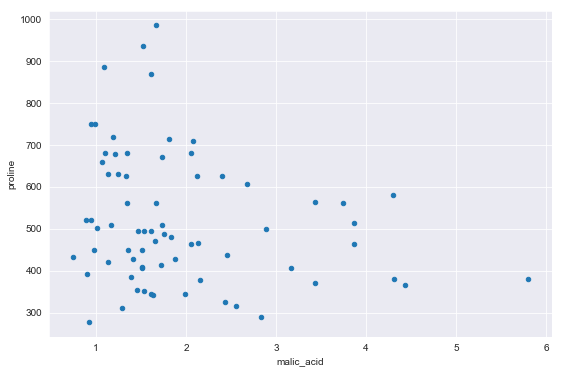

In [3]:
# example scatter plot showing how to features may vary together
use_ftrs = ['malic_acid', 'proline']
df = wine.loc[wine.target==1,use_ftrs]
df.plot.scatter(*use_ftrs)
    

In [4]:
def plot_covariance(mean_vec, cov):
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ax = df.plot.scatter(*use_ftrs)
    for j in range(1, 4):
        ell = Ellipse(xy=mean_vec,
                      width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])), 
                      color= 'teal', linestyle='--', alpha=0.7)
        ell.set_facecolor('none')
        ax.add_artist(ell)
    plt.xlim(0, 7)
    plt.ylim(100,1100)

#### Empirical Covariance

Plot 3 stds of the 2D Distribution

You can see the empirical covariance is broadened by extreme values in both features.

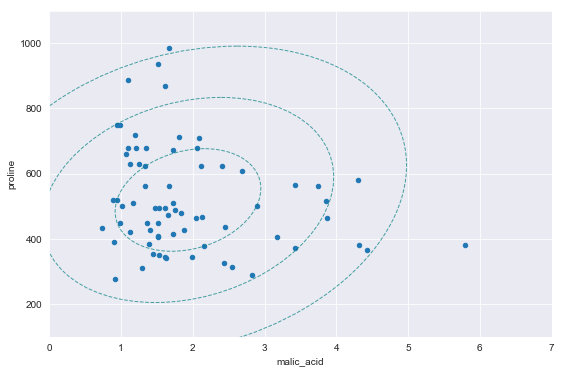

In [5]:
# Plot ellipsoids to illustrate std deviations 
# fromt the mean
mn = df.mean()
cov = df.cov()
plot_covariance(mn, cov)

The minimum covariance determinant finds a subset of data points for which the determinant of the covariance is minimized, and uses this subset to estimate the robust covariance.

You can see it produces a much tighter distribution around the most densely populated areas in the data.

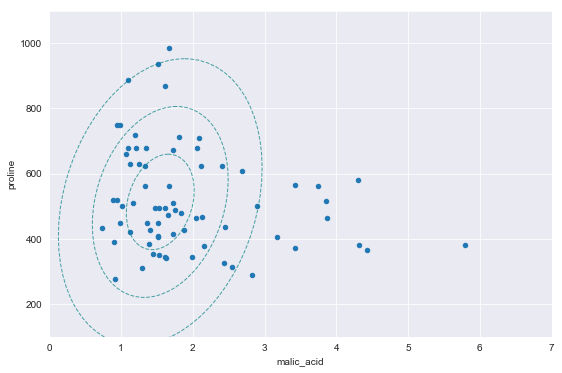

In [6]:
# With Robust Covariance
mcd = MinCovDet(random_state = 1111)
mcd.fit(df)

rmn = mcd.location_
rcov = mcd.covariance_
plot_covariance(rmn, rcov)

### My Implementation

Initial Determinant: 28849.171614389437
New Determinant 2138.0070933767092
New Determinant 1397.2269692359034
New Determinant 846.4853930492997
New Determinant 772.2142369932424
New Determinant 772.214236993243
New Determinant 772.214236993243 is greater than old determinant 772.2142369932424
Initial Determinant: 24649.04473777739
New Determinant 2276.231170645644
New Determinant 1076.4713904320988
New Determinant 833.7950659138305
New Determinant 795.1456041020185
New Determinant 795.1456041020185
Initial Determinant: 34773.49684973934
New Determinant 1997.21935260886
New Determinant 852.2272256735902
New Determinant 795.1456041020185
New Determinant 795.1456041020185


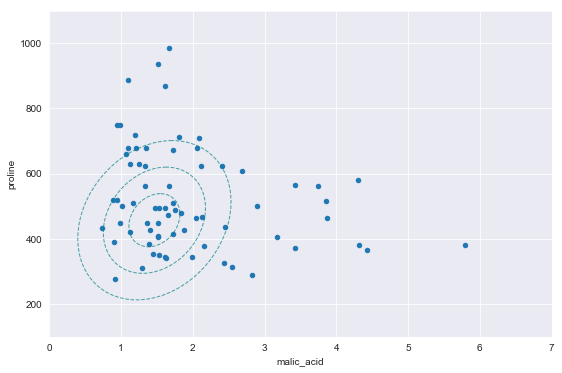

In [7]:
def min_cov_det(df, n_points=None, n_start=3):
    """
    Implementation of finding the Minimum Covariance Determinant estimate of a dataset
    for robust mean and covariance estimates.
    """
    n_points = n_points or int((sum(df.shape) + 1)/2)
    
    best = None
    # Since the algorithm is not guaranteed to return a global optimum
    #+ It's good to initialize it many times and take the subset
    # with the lowest determinant.
    for i in range(n_start):
        samp = df.sample(n_points)
        raw_mean, raw_cov = samp.mean(), samp.cov()
    
        # first iteration
        curr_mean, curr_cov = raw_mean, raw_cov
        curr_determinant = np.linalg.det(curr_cov)
        print("Initial Determinant:", curr_determinant)

        # At each iteration, choose a subset, use it to calculate mean and covariance
        # and then choose the next subset based on the data points that had
        # the smallest Mahalanobis distance given the currently calculated distribution.
        while True:
            # calculate mahalanobis distances from current mean using current cov for all samples
            dists = np.asarray([mahalanobis(row, curr_mean, np.linalg.inv(curr_cov)) for row in df.values])
            # take the smallest n_points points
            curr_idx = np.argsort(dists)[:n_points]
            # calculate new mean and covariance
            curr_mean, curr_cov = df.iloc[curr_idx].mean(), df.iloc[curr_idx].cov()
            new_determinant = np.linalg.det(curr_cov)
            print('New Determinant', new_determinant)
            # check stopping conditions
            if new_determinant > curr_determinant:
                print('New Determinant', new_determinant, "is greater than old determinant", curr_determinant)
            if np.isclose(new_determinant, 0, atol=0.001):
                best = curr_mean, curr_cov, curr_idx
                break
            elif np.isclose(curr_determinant-new_determinant, 0):
                best = curr_mean, curr_cov, curr_idx
                break
            curr_determinant = new_determinant
    return best
        
new_mn, new_cov, idx = min_cov_det(df)
plot_covariance(new_mn, new_cov)

N Points: 10
---------------
Initial Determinant: 19387.615465679035
New Determinant 33.021188395061706
New Determinant 16.127642469135804
New Determinant 16.127642469135804
Initial Determinant: 14489.082938024692
New Determinant 10.454799999999992
New Determinant 5.446381234567901
New Determinant 5.446381234567901
Initial Determinant: 5821.627456543211
New Determinant 24.305605185185165
New Determinant 16.977268395061735
New Determinant 16.977268395061735

N Points: 30
---------------
Initial Determinant: 19054.397048275856
New Determinant 592.1819078398732
New Determinant 430.076293412604
New Determinant 386.85938683313515
New Determinant 386.85938683313515
Initial Determinant: 21612.909512096732
New Determinant 1776.5345494649237
New Determinant 810.7200543797065
New Determinant 563.4130965755054
New Determinant 508.7897506856916
New Determinant 415.02000564407484
New Determinant 390.00816332936984
New Determinant 390.00816332936984
Initial Determinant: 25591.981026230656
New Determ

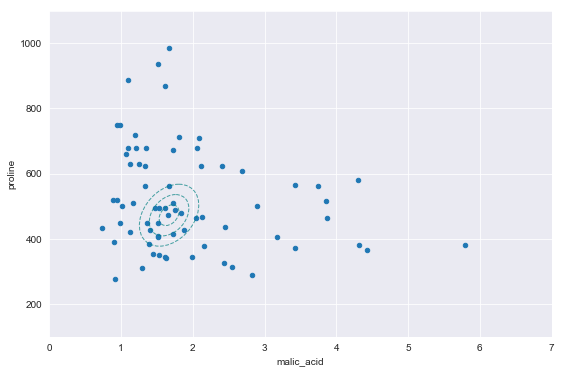

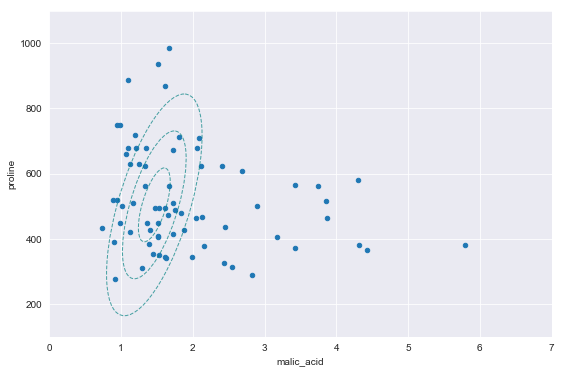

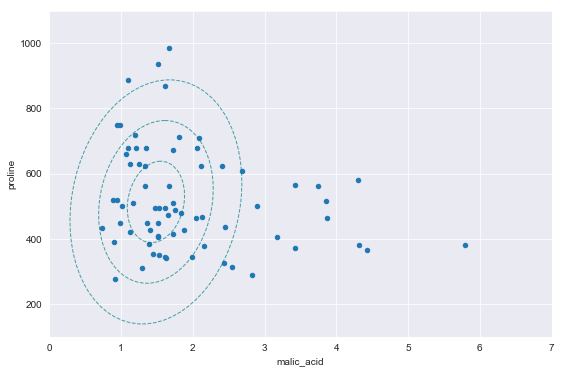

In [10]:
# The n_samples parameter does have a large effect on the results
for npt in [10,30,50]:
    print('N Points:', npt)
    print('---------------')
    

    new_mn, new_cov, idx = min_cov_det(df,n_points=npt)
    plot_covariance(new_mn, new_cov)
    print()